In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path

1. Forward Stepwise Selection

Use the Auto dataset from ISLP to predict mpg using all variables except name. Create a design matrix using ModelSpec, fit the full OLS model to estimate σ2, then perform forward stepwise selection using the Cp criterion with sklearn_selected and Stepwise.first_peak(). Report (a) the list of variables selected by stepwise selection, and (b) the final OLS coefficients for both the models.

In [3]:
# load the Auto dataset
data1 = load_data('Auto')
data1 = data1.dropna()
data1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [4]:
# define negative Cp function
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape #number of samples, number of features
    Yhat = estimator.predict(X) #predicted values
    RSS = np.sum((Y - Yhat)**2) #residual sum of squares
    return -(RSS + 2 * p * sigma2) / n

In [5]:
# Estimate sigma^2 using full model
design = MS(data1.columns.drop('mpg')).fit(data1) #design matrix
Y = np.array(data1['mpg']) #response vector
X = design.transform(data1) #design matrix as numpy array
sigma2 = OLS(Y,X).fit().scale #estimate of error variance


In [6]:
# Compute the negative Cp
neg_Cp = partial(nCp, sigma2) #partial function application to fix sigma2


In [7]:
# define stepwise selection strategy
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms)) 

In [8]:
# MSE-based selection
data1_MSE = sklearn_selected(OLS,
                               strategy) #use OLS as the estimator and our stepwise strategy defined above 
data1_MSE.fit(data1, Y) #fit the model to the data
print("MSE-based selection:")
print(data1_MSE.selected_state_) #show which variables were selected
print("MSE-based model coefficients:")
print(data1_MSE.model_.fit().params)

MSE-based selection:
('acceleration', 'cylinders', 'displacement', 'horsepower', 'origin', 'weight', 'year')
MSE-based model coefficients:
intercept      -17.218435
acceleration     0.080576
cylinders       -0.493376
displacement     0.019896
horsepower      -0.016951
origin           1.426140
weight          -0.006474
year             0.750773
dtype: float64


In [9]:
# Cp-based selection
data1_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp) #use OLS as the estimator and our stepwise strategy defined above 
data1_Cp.fit(data1, Y) #fit the model to the data
print("Cp-based selection:")
print(data1_Cp.selected_state_) #show which variables were selected
print("Cp-based model coefficients:")
print(data1_Cp.model_.fit().params)

Cp-based selection:
('origin', 'weight', 'year')
Cp-based model coefficients:
intercept   -18.045850
origin        1.150391
weight       -0.005994
year          0.757126
dtype: float64


2. Ridge Regression Analysis

Using the Auto dataset, implement ridge regression with a pipeline that includes standardization followed by ElasticNetCV(l1_ratio=0) with 5-fold cross-validation. Produce a plot of cross-validation error vs −log(λ) and clearly mark the optimal λ. Split the data into training and test sets (use a fixed random state for reproducibility), fit both ridge and OLS models, and report the test MSE for both. Provide a brief interpretation of whether ridge regression improves prediction performance compared to OLS.

In [65]:
from sklearn.model_selection import train_test_split, KFold
design = MS(data1.columns.drop('mpg')).fit(data1)
D = design.fit_transform(data1)
D = D.drop('intercept', axis=1) #drop intercept column
X = np.asarray(D)
y = np.array(data1['mpg'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [66]:
lambdas = 10**np.linspace(8, -2, 100) / y.std()

In [67]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create ridge regression pipeline with standardization
ridge_cv = skl.ElasticNetCV(
    alphas=lambdas,
    l1_ratio=0,  # Pure ridge regression (no lasso)
    cv=kfold,
    random_state=42
)

scaler = StandardScaler(with_mean=True,  with_std=True)
pipeline = Pipeline([
    ('scaler',scaler ),
    ('ridge', ridge_cv)
])
pipeline.fit(X_train, y_train)

print(f"Optimal lambda: {pipeline.named_steps['ridge'].alpha_:.4f}")

Optimal lambda: 0.0033


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.880e+03, tolerance: 1.376e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.en

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit OLS model for comparison
ols_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ols', LinearRegression())
])
ols_pipeline.fit(X_train, y_train)

# Make predictions on test set
ridge_pred = pipeline.predict(X_test)
ols_pred = ols_pipeline.predict(X_test)

# Calculate test MSE for both models
ridge_mse = mean_squared_error(y_test, ridge_pred)
ols_mse = mean_squared_error(y_test, ols_pred)

print(f"Ridge Regression Test MSE: {ridge_mse:.4f}")
print(f"OLS Regression Test MSE:   {ols_mse:.4f}")

Ridge Regression Test MSE: 10.1212
OLS Regression Test MSE:   10.0659


Ridge regression MSE is relatively higher than OLS regression MSE, because it introduces small bias to reduce variance.

3. Lasso Regression and Feature Selection

Using the Auto dataset, fit a lasso regression model with a pipeline that includes standardization followed by ElasticNetCV(l1_ratio=1) using 5-fold cross-validation. Create a coefficient path plot showing how the standardized coefficient estimates change as −log(λ) varies. Report the final coefficient estimates, the number of non-zero coefficients, and the test MSE. Compare the test MSE of lasso to that of ridge regression (from Question 2).

In [69]:
# Create ridge regression pipeline with standardization

scaler = StandardScaler(with_mean=True,  with_std=True)
lasso_cv = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold,
                           random_state=42)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lasso_cv)])
pipeCV.fit(X_train, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

print(f"Optimal lambda: {pipeCV.named_steps['lasso'].alpha_:.4f}")

Optimal lambda: 0.0204


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1613: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


In [70]:
Xs_train =  X_train - X_train.mean(0)[None,:] #think about what exactly is happening here. 
X_scale = X_train.std(0) #standard deviation of each column
Xs_train = Xs_train / X_scale[None,:]
lambdas, soln_array = skl.Lasso.path(Xs_train, 
                                    y_train,
                                    l1_ratio=1,
                                    n_alphas=100)[:2] #get solution array for lasso regression (l1_ratio=1)
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_59000\4288933704.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


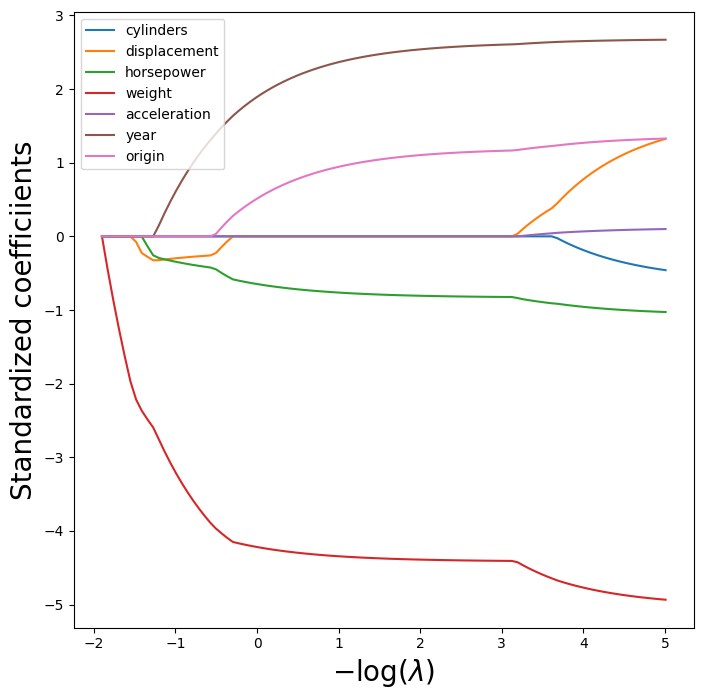

In [71]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False) 
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [75]:
print("Estimated Lasso Regression Coefficients:")

for i, (feature, coef) in enumerate(zip(D.columns, tuned_lasso.coef_)):
    print(f"{feature:<12}: {coef:8.4f}")

Estimated Lasso Regression Coefficients:
cylinders   :  -0.1449
displacement:   0.6821
horsepower  :  -0.9446
weight      :  -4.7401
acceleration:   0.0611
year        :   2.6482
origin      :   1.2595


In [79]:
non_zero_coefs = np.sum(np.abs(tuned_lasso.coef_) > 0)  # Use small threshold for numerical precision
zero_coefs = len(tuned_lasso.coef_) - non_zero_coefs
lasso_pred = pipeCV.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f"\nSparsity Analysis:")
print(f"Non-zero coefficients: {non_zero_coefs}")
print(f"Zero coefficients: {zero_coefs}")
print(f"Lasso Regression Test MSE: {lasso_mse:.4f}")


Sparsity Analysis:
Non-zero coefficients: 7
Zero coefficients: 0
Lasso Regression Test MSE: 10.2310


In [80]:

print(f"Ridge Regression Test MSE: {ridge_mse:.4f}")
print(f"Lasso Regression Test MSE: {lasso_mse:.4f}")
print(f"\nLasso vs Ridge:")
if lasso_mse < ridge_mse:
    improvement = ((ridge_mse - lasso_mse) / ridge_mse * 100)
    print(f"Lasso performs {improvement:.2f}% better than Ridge")
else:
    degradation = ((lasso_mse - ridge_mse) / ridge_mse * 100)
    print(f"Lasso performs {degradation:.2f}% worse than Ridge")

Ridge Regression Test MSE: 10.1212
Lasso Regression Test MSE: 10.2310

Lasso vs Ridge:
Lasso performs 1.08% worse than Ridge


4. Principal Components and Partial Least Squares

 Using the Boston dataset to predict medv, first apply Principal Components Regression (PCR) by constructing a pipeline with standardization and PCA followed by linear regression. Use GridSearchCV with 5-fold cross-validation to choose the optimal number of components (search from 1 to the full number of predictors) and plot CV MSE vs number of components. Then repeat the process using Partial Least Squares (PLS) regression, again choosing the optimal number of components via cross-validation. Report the optimal number of components and test MSE for both PCR and PLS, and briefly discuss which method achieves better performance and why. 

5. Comprehensive Model Comparison

Split the Boston dataset into 70% training and 30% test sets (set random state to 77 for reproducibility). Using the training data only, tune hyperparameters via cross-validation where applicable, and fit each of the following models: OLS, forward stepwise selection (with Cp and Stepwise.first_peak()), ridge regression (ElasticNetCV with l1_ratio=0), lasso regression (ElasticNetCV with l1_ratio=1), PCR, and PLS (PCR and PLS NOT REQUIRED). Evaluate all six models on the same test set and create a single bar chart (or table) comparing the test MSE values across all models. Identify the best-performing method based on test MSE.